In [1]:
%load_ext autoreload
%autoreload 2
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import scanpy_helpers.de as de
from scanpy_helpers.annotation import AnnotationHelper
from warnings import filterwarnings
from pygenesig.gini import GiniSignatureGenerator
import itertools
import matplotlib.pyplot as plt

sc.settings.verbosity = 2

filterwarnings("ignore", category=FutureWarning)
sc.set_figure_params(figsize=(5, 5))
import re

In [2]:
output_dir = "../../data/50_myeloid_cells/30_de_analysis"
deploy_dir = "../../deploy/Ab1MxvlS9c56BaA0Z94J/figures/"

In [3]:
adata = sc.read_h5ad(
    "../../data/50_myeloid_cells/20_cell_type_annotation/adata_annotated.h5ad"
)
adata_scvi = sc.read_h5ad(
    "../../data/50_myeloid_cells/01_myeloid_subset/adata_scvi.h5ad"
)

The two anndata objects are the same, except `adata` contains log-normalized counts and the cell-type annotations, whereas `adata_scvi` just contains the raw counts

In [4]:
assert adata.shape == adata_scvi.shape

In [5]:
adata.obs["cell_type"] = de._make_names(adata.obs["cell_type"])
adata._sanitize()

... storing 'cell_type' as categorical


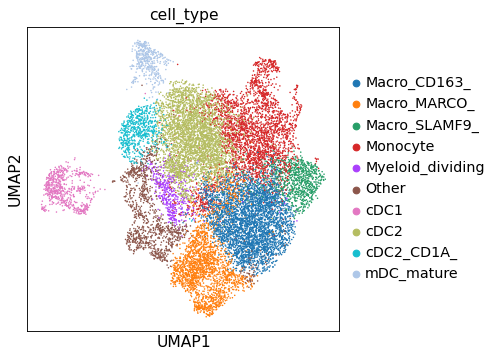

In [6]:
sc.pl.umap(adata, color="cell_type")

# DE analysis

According to [this benchmark](https://pubmed.ncbi.nlm.nih.gov/29481549/), edgeR and MAST are among the best methods for 
DE analysis of single cells. In any case, the authors recommend to include the number of detected genes into the model. 
Moreover, the model needs to correct for batch effects arising from different patients and dataset:

      `~ 1 + cell_type + sample + n_genes`. 

I tried different approaches for DE analysis:

* `edgeR` way too slow given the number of cells and categories. Aborted after 72h. 
* `glmGamPoi` claims to be a faster version of edge R. Completed after 6 hours on a subset of 500 cells. Still way too slow. 
* `scVI` provides a method for batch-corrected differential expression analysis based on the same autoencode used for integrating the data. It is very fast (few minutes) and their [preprint claims](https://www.biorxiv.org/content/10.1101/794289v1) superior performance over MAST and edgeR. 
* `MAST`, while being slower than `scVI` is also based on a linear model. It can be massively parallelized and completed on the entire dataset in 2:30h on 44 cores. 
* `Gini-Index` is not a DE-appraoch *per se*, but a useful approach to identify marker genes based on information gain

In the following I will show the results of `scVI` and `MAST` and `Gini-Index`. 


## Results summary
 * big overlap between scVI and gini. 
 * MAST fold changes don't rank marker genes for specific clusters very high. Top hits tend to be markers for multiple clusters (e.g. Macrophages rather than M1/M2/M0). 

## Run the DE methods
### scVI

In [7]:
adata_scvi.obs["cell_type"] = adata.obs["cell_type"]
scvi.data.setup_anndata(adata_scvi, batch_key="sample")
model = scvi.model.SCVI.load(
    f"../../data/50_myeloid_cells/20_cell_type_annotation/scvi_model_all_genes",
    adata_scvi,
)

# try to load from cache
try:
    scvi_res = pd.read_csv(f"{output_dir}/scvi_res.csv", index_col=0)
except FileNotFoundError:
    scvi_res = de.scvi(adata_scvi, model, groupby="cell_type")
    scvi_res.to_csv(f"{output_dir}/scvi_res.csv")

scvi_res.index.name = "gene_symbol"
scvi_res.reset_index(inplace=True)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/data/scratch/sturm/conda/envs/2021-nsclc_heterogeneity-scanpy/lib/python3.8/site-packages/scvi/data/_anndata.py:709: UserWarning: Category 6 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(


INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 15817 cells, 17567 vars, 80       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/data/scratch/sturm/conda/envs/2021-nsclc_heterogeneity-scanpy/lib/python3.8/site-packages/scvi/data/_anndata.py:709: UserWarning: Category 6 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15817 cells, 17567 vars, 80       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


### MAST

In [8]:
%%time
try:
    mast_res = pd.read_csv(f"{output_dir}/mast_res.csv", index_col=0)
except FileNotFoundError:
    mast_res = de.mast(
        adata,
        groupby="cell_type",
        groups="all",
        cofactors=["sample", "n_genes"],
        n_jobs=16,
        n_cores_per_job=4,
    )
    mast_res.to_csv(f"{output_dir}/mast_res.csv")

CPU times: user 164 ms, sys: 21.1 ms, total: 185 ms
Wall time: 210 ms


### Gini-index

In [9]:
%%time
# run signature generator without cutoff, can threshold later
sg = GiniSignatureGenerator(
    adata.X.toarray().astype(float).T,
    target=adata.obs["cell_type"].values,
    min_expr=0,
    min_gini=0,
    aggregate_fun=np.mean,
    max_rk=1,
    max_rel_rk=1,
)
gini_res = sg.get_rogini_format()

CPU times: user 25.3 s, sys: 1.36 s, total: 26.7 s
Wall time: 26.8 s


## DE Results

### scVI

* scVI uses logBayesFactor as main output statistic. The log bayes factors are to be interpreted as described [here](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scVI_DE_worm.html#Interpreting-Bayes-factors). `proba_not_de` can be interpreted as a FDR-corrected p-value. 
* a lot of the top hits that are very sparsely expressed in one cell-type and not at all in the other cell-types. While the signal is probably real, these genes are still bad candidate markers as they are hardly expressed. Below is an example of "TEX11" which is expressed in 8 cells in total - 7 of them are DC Lagerhans. 
* Alternatively, I rank genes by their log-fold change require the minimum expression to be >= 0.5

#### TEX11 is a top hit, but a bad marker

In [10]:
adata.obs["_TEX11"] = (adata[:, "TEX11"].X.todense().A1 > 0).astype(str)

... storing '_TEX11' as categorical


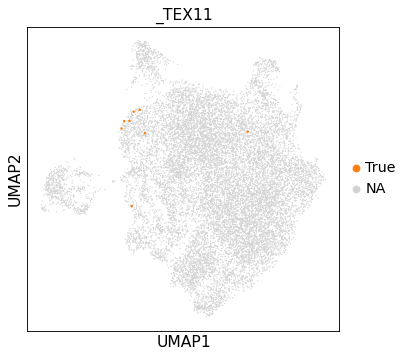

In [11]:
sc.pl.umap(
    adata,
    color="_TEX11",
    groups="True",
    size=[20 if x == "True" else 5 for x in adata.obs["_TEX11"]],
)

In [12]:
scvi_res

gene_symbol  proba_de  proba_not_de  bayes_factor    scale1  \
0             DPYS  0.970766      0.029234      3.502757  0.000005   
1         STK4-AS1  0.964919      0.035081      3.314395  0.000002   
2            CCL13  0.964516      0.035484      3.302548  0.000418   
3           LRRC70  0.963911      0.036089      3.285019  0.000004   
4            MMP10  0.962702      0.037298      3.250793  0.001335   
...            ...       ...           ...           ...       ...   
175665     TMEM258  0.541331      0.458669      0.165701  0.000263   
175666      HNRNPC  0.539718      0.460282      0.159206  0.000256   
175667        TRIR  0.535685      0.464315      0.142985  0.000226   
175668        PPIA  0.535484      0.464516      0.142174  0.000856   
175669       TCF25  0.533669      0.466331      0.134882  0.000153   

              scale2  lfc_mean  lfc_median   lfc_std    lfc_min    lfc_max  \
0       8.761855e-07  3.613880    3.489060  2.857856  -6.786573  18.268360   
1       5.072377e-07  3.015036    2.886162  2.311303  -4.506130  17.706509   
2       9.054983e-05  3.050438    2.956967  2.229543  -5.418306  13.538488   
3       1.053423e-06  3.650204    3.325602  2.956225  -4.434793  27.913164   
4       4.462368e-04  4.041575    3.598510  4.710840 -14.810193  25.309109   
...              ...       ...         ...       ...        ...        ...   
175665  2.683380e-04 -0.067150   -0.061975  0.482180  -2.630200   2.910636   
175666  2.709068e-04 -0.089161   -0.070334  0.437392  -2.416721   3.223967   
175667  2.164721e-04  0.053978    0.089725  0.441059  -2.379899   1.744867   
175668  8.815223e-04 -0.032751   -0.010470  0.462076  -2.007140   2.481561   
175669  1.539508e-04  0.024361    0.024007  0.454595  -2.301592   1.981318   

         raw_mean1   raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
0         0.318612    0.034063               0.012618               0.002920   
1         0.306854    0.080049               0.001147               0.000730   
2        39.620591   19.666504               0.389447               0.066504   
3         0.018641    0.114842               0.001434               0.000730   
4         0.934328    0.217275               0.002868               0.008759   
...            ...         ...                    ...                    ...   
175665   20.220657   31.561627               0.708920               0.773829   
175666   25.375587   34.100383               0.730047               0.749659   
175667   35.018779   25.802937               0.713615               0.706062   
175668  103.093897  147.726983               0.929577               0.925866   
175669   18.946009   23.342213               0.514085               0.561432   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
0                   0.019903              0.005054            True   
1                   0.003376              0.000409            True   
2                   5.641551              0.511320            True   
3                   0.000908              0.001513            True   
4                   0.007318              0.050816            True   
...                      ...                   ...             ...   
175665              2.201140              2.888618           False   
175666              2.481719              2.558684           False   
175667              2.278377              2.143984           False   
175668              7.282371              8.103140           False   
175669              1.319850              1.340984           False   

                  comparison  
0       Macro_CD163_ vs Rest  
1       Macro_CD163_ vs Rest  
2       Macro_CD163_ vs Rest  
3       Macro_CD163_ vs Rest  
4       Macro_CD163_ vs Rest  
...                      ...  
175665    mDC_mature vs Rest  
175666    mDC_mature vs Rest  
175667    mDC_mature vs Rest  
175668    mDC_mature vs Rest  
175669    mDC_mature vs Rest  

[175670 rows x 19 columns]

#### Results based on alternative scoring strategy
 * rank by log-fold change, require minimal expression level

In [13]:
scvi_res["score"] = scvi_res["lfc_mean"] * (scvi_res["raw_normalized_mean1"] > 0.5)
# de_res["score"] = de_res["bayes_factor"] * (de_res["raw_normalized_mean2"] - de_res["raw_normalized_mean1"]) * -1

In [14]:
scvi_res["cell_type"] = [x.split("vs")[0].strip() for x in scvi_res["comparison"]]

In [15]:
de.de_res_to_anndata(
    adata,
    scvi_res,
    groupby="cell_type",
    gene_id_col="gene_symbol",
    pval_col="proba_not_de",
    pval_adj_col="proba_not_de",
    lfc_col="lfc_mean",
)

#### Top genes for each group
score = log fold change

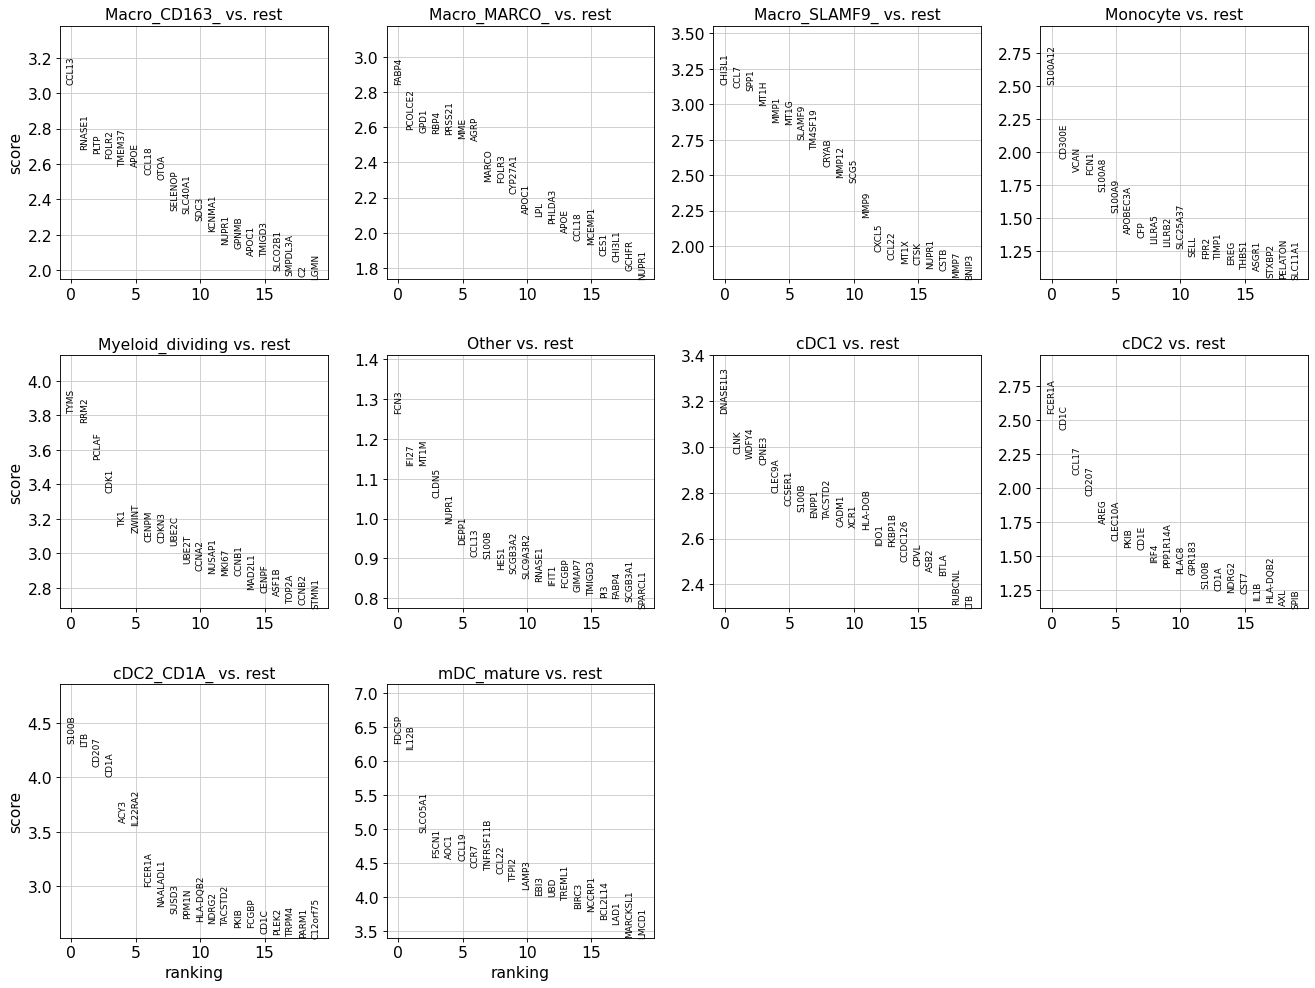

In [16]:
sc.pl.rank_genes_groups(adata, sharey=False)

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:49)
Storing dendrogram info using `.uns['dendrogram_cell_type']`


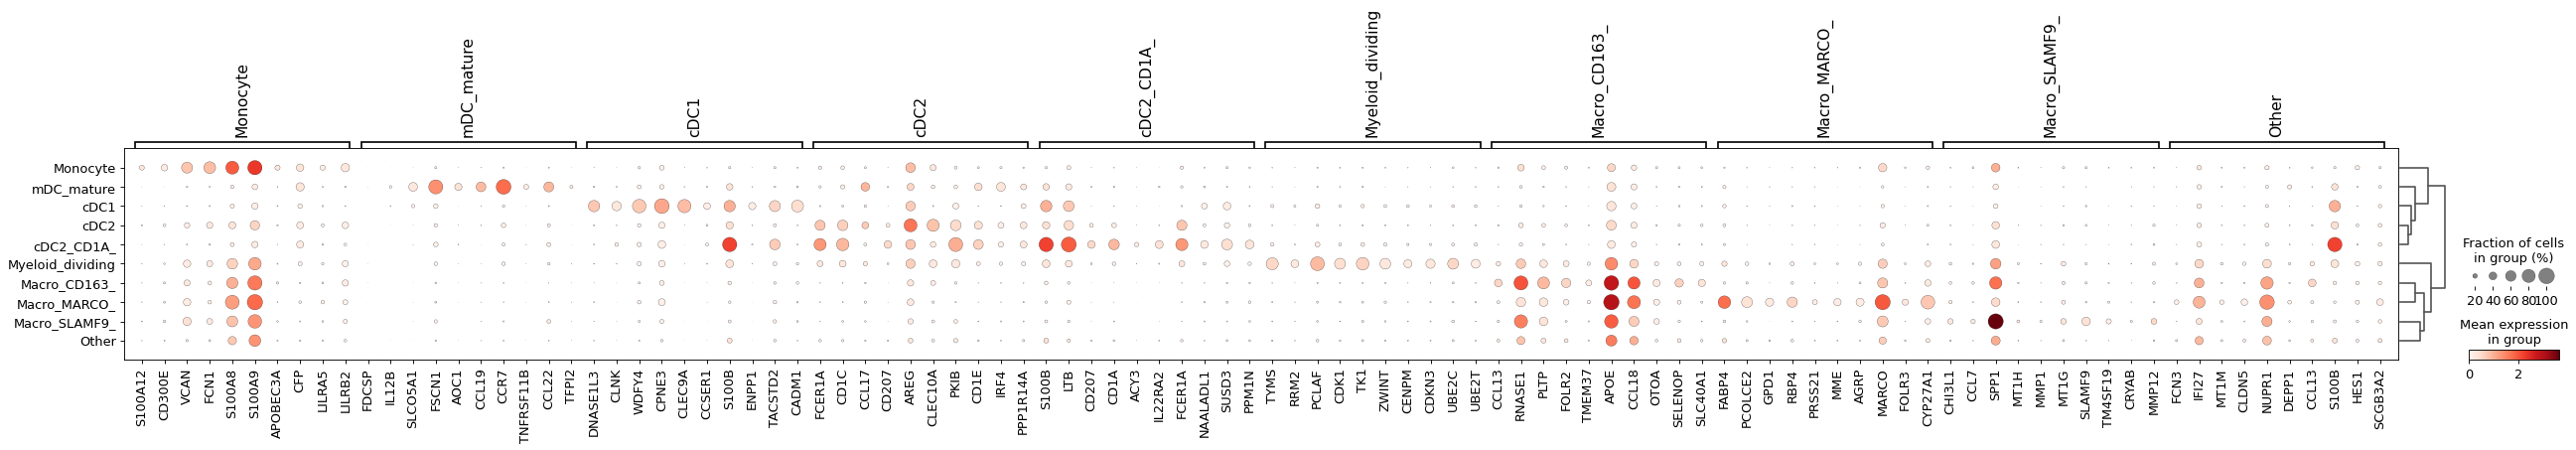

In [17]:
ax = sc.pl.rank_genes_groups_dotplot(adata, show=False)
fig = ax["mainplot_ax"].get_figure()
fig.savefig(f"{deploy_dir}/dotplot_myeloid_markers_scvi.pdf", bbox_inches="tight")

On first glance, the markers make sense: 

* CCR7 is the marker that was used for classifying mDC mature in the first place
* CDK1 is a marker for dividing cells
* Visual inspection of the top hits on UMAP are clearly restricted to a subset of cells (see "Plots" section at the end of the notebook) 

### MAST

 * Due to the immense statistical power arising from 15k cells, almost all differences between cells become statistically significant. In fact many comparisons hava a p-value of 0. 
 * Ranking by p-value (only) is therefore not viable to find marker genes. Ranking by log-fold change instead
 * Top MAST hits appear to be specific for several clusters, not a single one. 


#### APOE is a top hit for Macrophage M0, but also M1 and M2

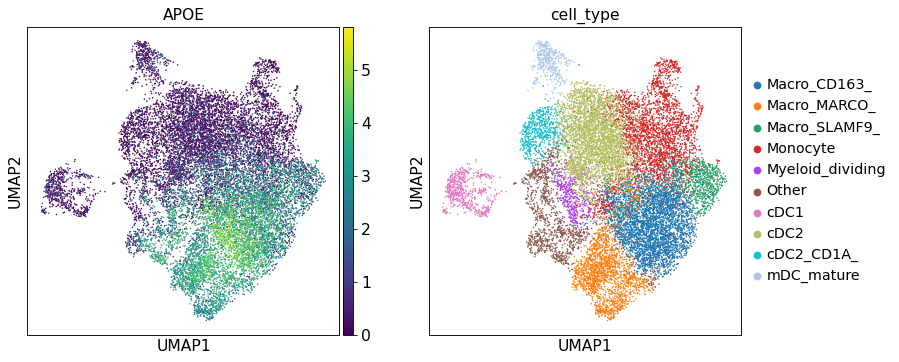

In [18]:
sc.pl.umap(adata, color=["APOE", "cell_type"])

In [19]:
# replace 0-pvalues with minimum nonzero pvalue.
mast_res["cell_type"] = mast_res["comparison"]
mast_res.loc[mast_res["coef"].isnull(), "coef"] = 0
mast_res.loc[mast_res["Pr(>Chisq)"] == 0, "Pr(>Chisq)"] = np.min(
    mast_res["Pr(>Chisq)"][mast_res["Pr(>Chisq)"] != 0]
)
mast_res["score"] = mast_res["coef"]

In [20]:
mast_res.sort_values("score")

primerid     Pr(>Chisq)      coef    comparison     cell_type  \
33669     TYROBP  9.881313e-324 -2.464660          cDC1          cDC1   
132361  MTCO1P21  3.215264e-116 -2.121543         Other         Other   
146072       FTL  5.568892e-126 -1.922741    mDC_mature    mDC_mature   
96381        LYZ  9.881313e-324 -1.921086    cDC2_CD1A_    cDC2_CD1A_   
88790      APOC1  1.071573e-124 -1.907300    cDC2_CD1A_    cDC2_CD1A_   
...          ...            ...       ...           ...           ...   
110332     FABP4  9.881313e-324  1.929553  Macro_MARCO_  Macro_MARCO_   
156617       TXN  9.881313e-324  2.135050    mDC_mature    mDC_mature   
44526   MTCO1P21   1.327029e-80  2.193949  Macro_CD163_  Macro_CD163_   
21082       CST3  9.881313e-324  2.403654          cDC1          cDC1   
114795  MTCO2P31   1.342403e-52  2.445671  Macro_MARCO_  Macro_MARCO_   

           score  
33669  -2.464660  
132361 -2.121543  
146072 -1.922741  
96381  -1.921086  
88790  -1.907300  
...          ...  
110332  1.929553  
156617  2.135050  
44526   2.193949  
21082   2.403654  
114795  2.445671  

[175670 rows x 6 columns]

In [21]:
de.de_res_to_anndata(
    adata,
    mast_res,
    groupby="cell_type",
    gene_id_col="primerid",
    pval_col="Pr(>Chisq)",
    lfc_col="coef",
    score_col="coef",
)

#### Top genes for each group
score = log fold change

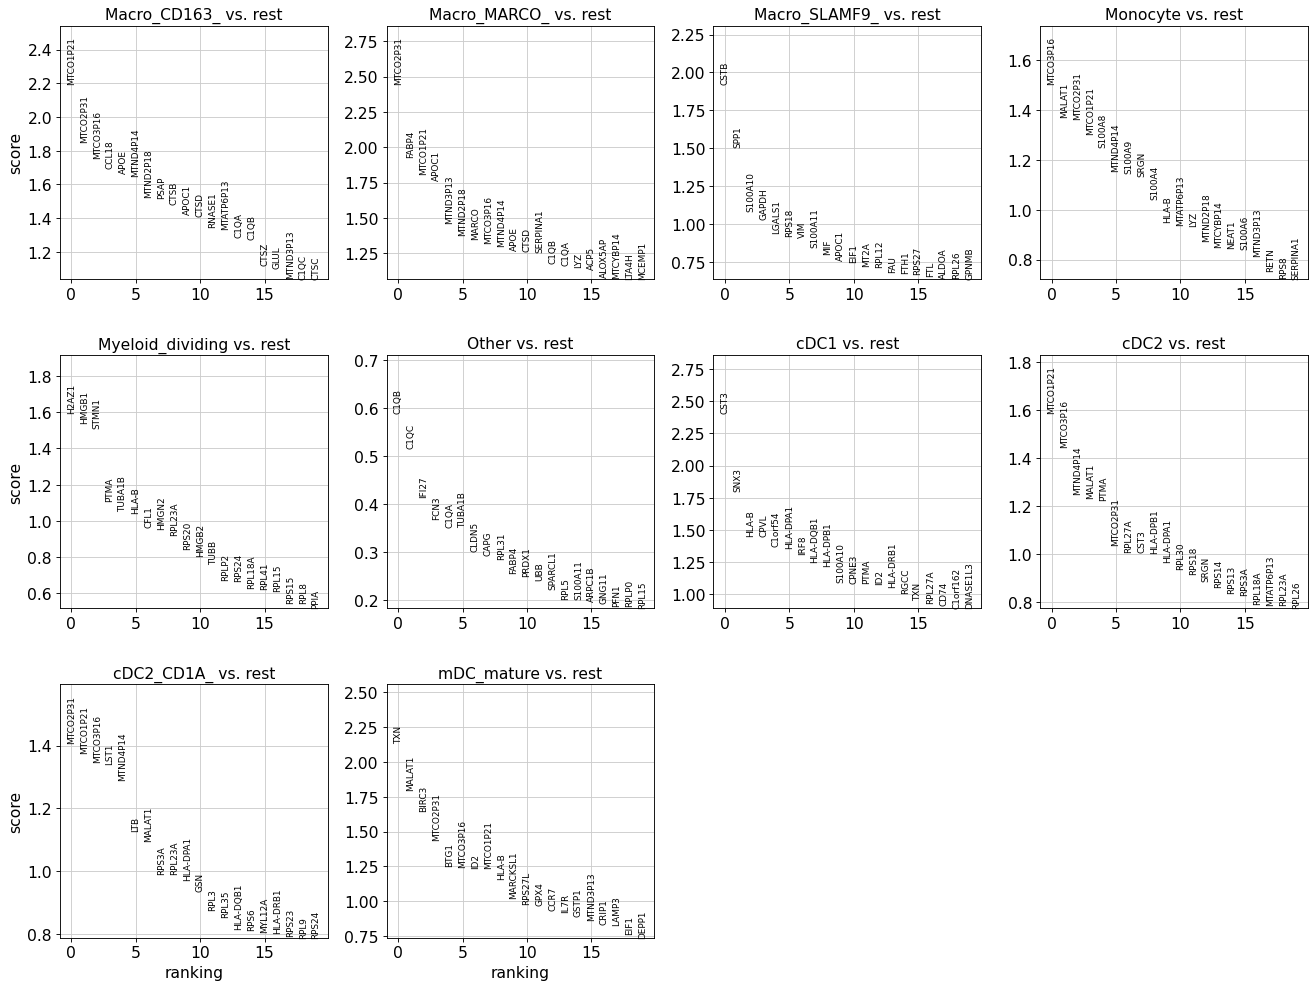

In [22]:
sc.pl.rank_genes_groups(adata, sharey=False)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


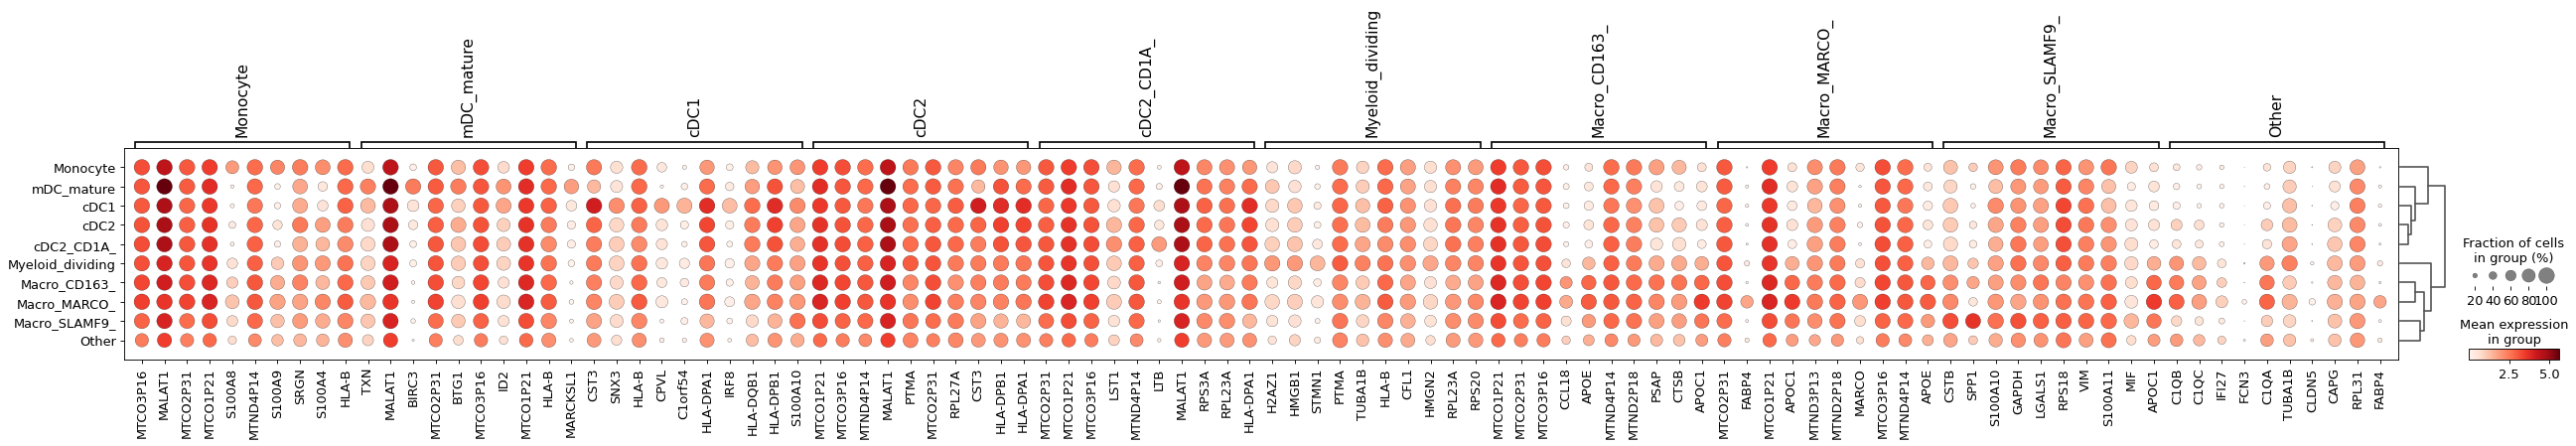

In [23]:
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata)

### Gini-Index

In [24]:
gini_res = gini_res.sort_values(["CATEGORY", "GINI_IDX"], ascending=[True, False])

In [25]:
gini_res["GENE_SYMBOL"] = [adata.var_names[i] for i in gini_res["GENEID"]]

In [26]:
# merge MAST and gini results
gini_mast_df = gini_res.merge(
    mast_res,
    how="inner",
    left_on=["GENE_SYMBOL", "CATEGORY"],
    right_on=["primerid", "cell_type"],
)

 * VALUE = average gene expression in CATEGORY
 * Pr(>Chisq) = p-value for that gene from the MAST analysis (CATEGORY vs rest) 
 * coef = MAST log fold change

In [27]:
gini_mast_df

GENEID      CATEGORY     VALUE  RANKING  GINI_IDX GENE_SYMBOL  \
0        6700  Macro_CD163_  0.000504      1.0  0.900000     HSD17B3   
1        1173  Macro_CD163_  0.000403      1.0  0.900000        ARTN   
2        1833  Macro_CD163_  0.000160      1.0  0.900000    C17orf50   
3        8248  Macro_CD163_  0.000120      1.0  0.900000   LINC01615   
4        7633  Macro_CD163_  0.000087      1.0  0.900000     KLHDC8A   
...       ...           ...       ...      ...       ...         ...   
17553   12825    mDC_mature  3.599080      1.0  0.054642       RPL10   
17554   10844    mDC_mature  0.033819      1.0  0.052998       PEX26   
17555   12839    mDC_mature  2.774838      1.0  0.046619       RPL21   
17556    1415    mDC_mature  4.416302      1.0  0.031241         B2M   
17557   15516    mDC_mature  3.967236      1.0  0.021584      TMSB10   

        primerid    Pr(>Chisq)      coef    comparison     cell_type     score  
0        HSD17B3  8.726251e-02  0.000000  Macro_CD163_  Macro_CD163_  0.000000  
1           ARTN  2.948284e-02  0.000000  Macro_CD163_  Macro_CD163_  0.000000  
2       C17orf50  1.681619e-01  0.000000  Macro_CD163_  Macro_CD163_  0.000000  
3      LINC01615  2.001769e-01  0.000000  Macro_CD163_  Macro_CD163_  0.000000  
4        KLHDC8A  1.623505e-01  0.000000  Macro_CD163_  Macro_CD163_  0.000000  
...          ...           ...       ...           ...           ...       ...  
17553      RPL10  1.488482e-31  0.281681    mDC_mature    mDC_mature  0.281681  
17554      PEX26  3.852972e-01  0.001597    mDC_mature    mDC_mature  0.001597  
17555      RPL21  7.716481e-17  0.375116    mDC_mature    mDC_mature  0.375116  
17556        B2M  1.594086e-90  0.511211    mDC_mature    mDC_mature  0.511211  
17557     TMSB10  7.679147e-64  0.262146    mDC_mature    mDC_mature  0.262146  

[17558 rows x 12 columns]

In [28]:
gini_res

GENEID      CATEGORY     VALUE  RANKING  GINI_IDX GENE_SYMBOL
6698     6700  Macro_CD163_  0.000504      1.0  0.900000     HSD17B3
1173     1173  Macro_CD163_  0.000403      1.0  0.900000        ARTN
1833     1833  Macro_CD163_  0.000160      1.0  0.900000    C17orf50
8242     8248  Macro_CD163_  0.000120      1.0  0.900000   LINC01615
7629     7633  Macro_CD163_  0.000087      1.0  0.900000     KLHDC8A
...       ...           ...       ...      ...       ...         ...
12819   12825    mDC_mature  3.599080      1.0  0.054642       RPL10
10838   10844    mDC_mature  0.033819      1.0  0.052998       PEX26
12833   12839    mDC_mature  2.774838      1.0  0.046619       RPL21
1415     1415    mDC_mature  4.416302      1.0  0.031241         B2M
15508   15516    mDC_mature  3.967236      1.0  0.021584      TMSB10

[17558 rows x 6 columns]

In [29]:
gini_mast_df.to_csv(f"{output_dir}/gini_mast_res.csv")

In [30]:
gini_df_filtered = gini_mast_df.loc[
    (gini_mast_df["VALUE"] > 0.1)
    & (gini_mast_df["GINI_IDX"] > 0.6)
    & (gini_mast_df["Pr(>Chisq)"] < 0.01 / gini_mast_df.shape[0]),
    :,
]

In [31]:
gini_signatures = {
    cat: df.sort_values("VALUE", ascending=False)["GENE_SYMBOL"].values[:10]
    for cat, df in gini_df_filtered.groupby("CATEGORY")
}

In [32]:
var_group_labels = list(gini_signatures.keys())
c = -1
var_group_positions = [
    (c := c + 1, (c := c + len(group) - 1)) for group in gini_signatures.values()
]

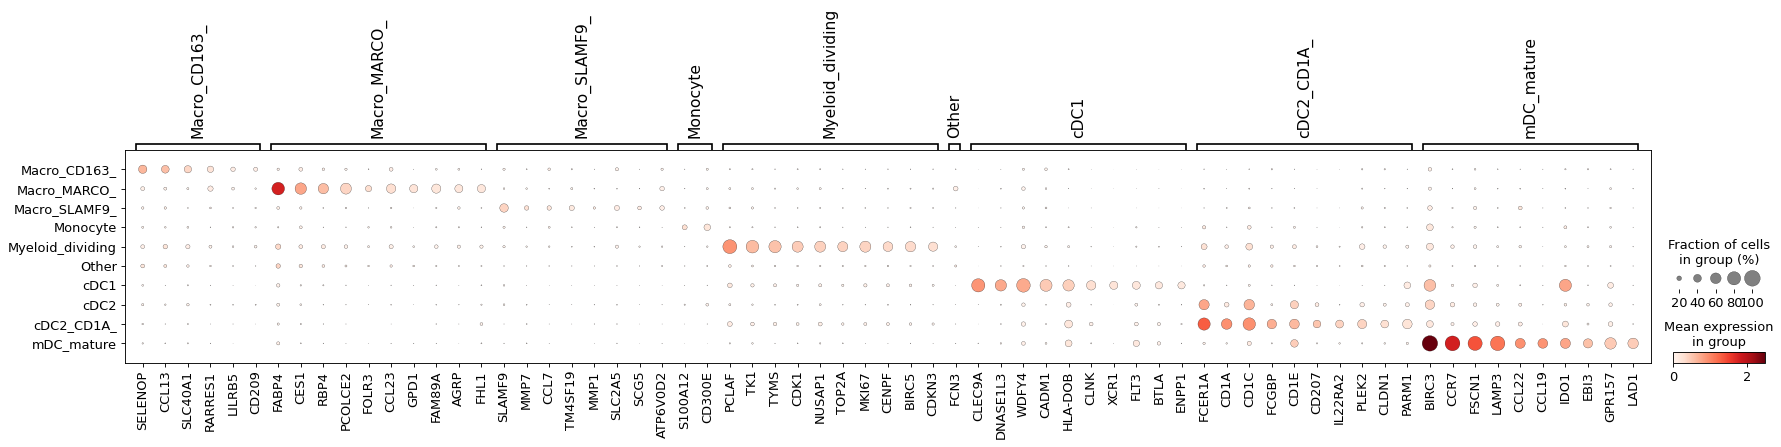

In [33]:
ax = sc.pl.dotplot(
    adata,
    groupby="cell_type",
    var_names=list(itertools.chain.from_iterable(gini_signatures.values())),
    var_group_labels=var_group_labels,
    var_group_positions=var_group_positions,
    show=False
)
fig = ax["mainplot_ax"].get_figure()
fig.savefig(f"{deploy_dir}/dotplot_myeloid_markers_gini.pdf", bbox_inches="tight")

### Create dataframe with all results

In [34]:
de_all_results = (
    gini_mast_df.merge(
        scvi_res.rename(columns={"score": "scvi_score"}).drop(columns=["comparison"]),
        left_on=["GENE_SYMBOL", "cell_type"],
        right_on=["gene_symbol", "cell_type"],
    )
    .drop(
        columns=[
            "primerid",
            "GENEID",
            "RANKING",
            "comparison",
            "CATEGORY",
            "gene_symbol",
            "proba_de",
            "scale1",
            "scale2",
            "lfc_median",
            "lfc_std",
            "lfc_min",
            "lfc_max",
            "is_de_fdr_0.05",
        ]
    )
    .rename(
        columns={
            "VALUE": "mean_expr_in_cell_type",
            "Pr(>Chisq)": "mast_pvalue",
            "coef": "mast_coef",
            "score": "mast_score",
            "proba_not_de": "scvi_adjusted_pvalue",
            "bayes_factor": "scvi_log_bayes_factor",
            "lfc_mean": "scvi_lfc_mean",
            "raw_mean1": "scvi_raw_mean1",
            "raw_mean2": "scvi_raw_mean2",
            "non_zeros_proportion1": "scvi_non_zeros_proportion1",
            "non_zeros_proportion2": "scvi_non_zeros_proportion2",
            "raw_normalized_mean1": "scvi_raw_normalized_mean1",
            "raw_normalized_mean2": "scvi_raw_normalized_mean2",
            "GENE_SYMBOL": "gene_symbol"
        }
    )
)

In [35]:
de_all_results.to_csv(f"{output_dir}/de_all_results.csv")
de_all_results.to_csv(f"{deploy_dir}/de_all_results.csv")

### Compare gini against scVI

In [36]:
top10_scvi = set(
    list(
        scvi_res.sort_values("score", ascending=False)
        .groupby("cell_type")
        .apply(lambda x: x["gene_symbol"][:10])
        .reset_index()["gene_symbol"]
        .values
    )
)
top_gini = set(list(itertools.chain.from_iterable(gini_signatures.values())))
top_both = top10_scvi & top_gini
rest = set(de_all_results["gene_symbol"]) - top10_scvi - top_gini

Scatterplot of gini index against scVI Bayes Factor. Genes with a high gini index also have a high bayes factor. 

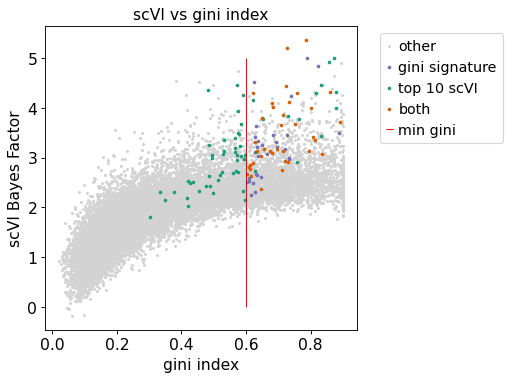

In [37]:
fig, ax = plt.subplots()
df_background = de_all_results.loc[de_all_results["gene_symbol"].isin(rest), :]
df_top10_scvi = de_all_results.loc[de_all_results["gene_symbol"].isin(top10_scvi - top_both), :]
df_top_gini = de_all_results.loc[de_all_results["gene_symbol"].isin(top_gini - top_both), :]
df_top_both = de_all_results.loc[de_all_results["gene_symbol"].isin(top_both), :]
background = ax.scatter(
    df_background["GINI_IDX"], df_background["scvi_log_bayes_factor"], c="lightgrey", s=3
)
background.set_label("other")
tmp_sc = ax.scatter(
    df_top_gini["GINI_IDX"], df_top_gini["scvi_log_bayes_factor"], c="#7570b3", s=5
)
tmp_sc.set_label("gini signature")
tmp_sc = ax.scatter(
    df_top10_scvi["GINI_IDX"], df_top10_scvi["scvi_log_bayes_factor"], c="#1b9e77", s=5
)
tmp_sc.set_label("top 10 scVI")
tmp_sc = ax.scatter(
    df_top_both["GINI_IDX"], df_top_both["scvi_log_bayes_factor"], c="#d95f02", s=5
)
tmp_sc.set_label("both")
red_line = ax.vlines(x=[0.6], ymin=0, ymax=5, color="red", lw=1)
red_line.set_label("min gini")
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title("scVI vs gini index")
ax.set_xlabel("gini index")
ax.set_ylabel("scVI Bayes Factor")
ax.grid(False)

The same plot colored by the epression cutoff used for finding gini signature genes. 
Genes witha high gini index tend to be expressed at a lower level. 

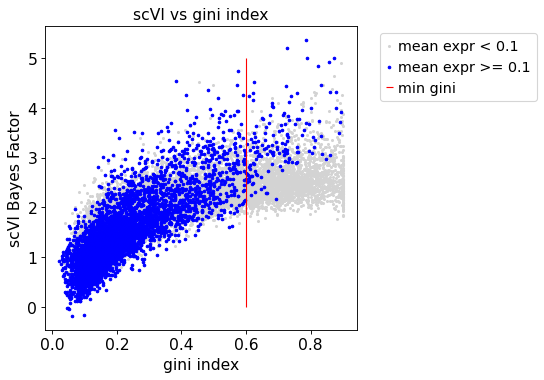

In [38]:
fig, ax = plt.subplots()
df_background = de_all_results.loc[de_all_results["mean_expr_in_cell_type"] < 0.1, :]
df_expr = de_all_results.loc[de_all_results["mean_expr_in_cell_type"] >= 0.1, :]
tmp_sc = ax.scatter(
    df_background["GINI_IDX"], df_background["scvi_log_bayes_factor"], c="lightgrey", s=3
)
tmp_sc.set_label("mean expr < 0.1")
tmp_sc = ax.scatter(df_expr["GINI_IDX"], df_expr["scvi_log_bayes_factor"], c="blue", s=5)
tmp_sc.set_label("mean expr >= 0.1")
red_line = ax.vlines(x=[0.6], ymin=0, ymax=5, color="red", lw=1)
red_line.set_label("min gini")
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title("scVI vs gini index")
ax.set_xlabel("gini index")
ax.set_ylabel("scVI Bayes Factor")
ax.grid(False)

## Plot marker genes


### Cell-type markers
Top markers tend to be in the top hits of both gini and scVI

DC Lagerhans


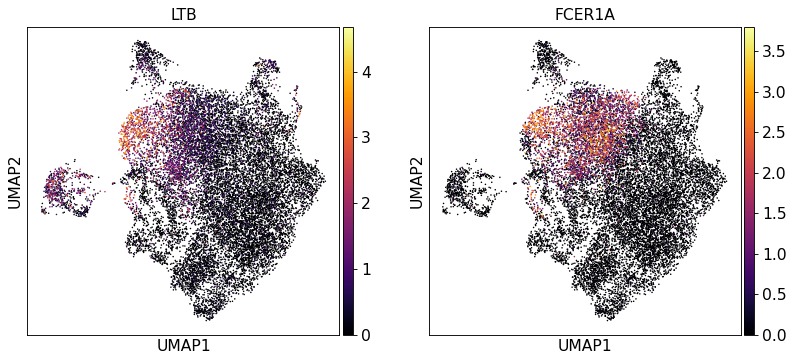

MDSC


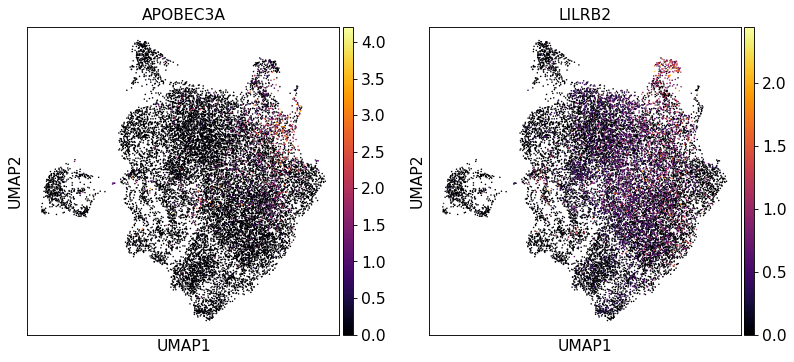

Macro M0


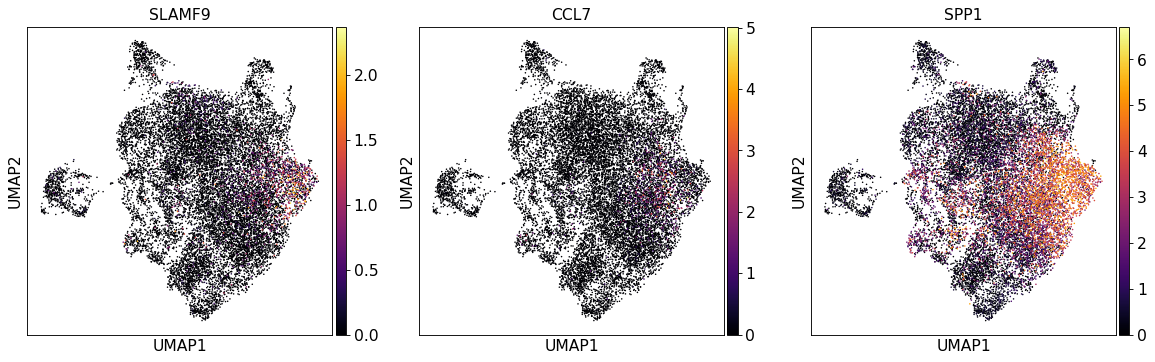

Macro M1


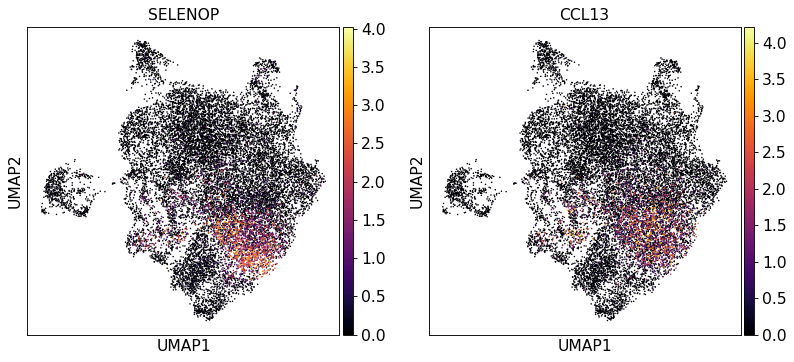

Macro M2 (alevolar)


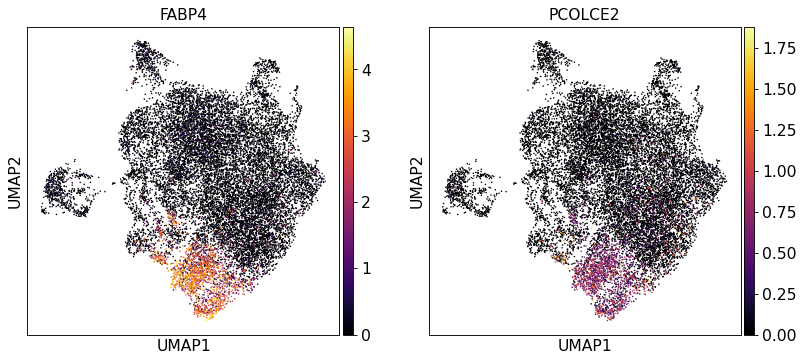

Mono


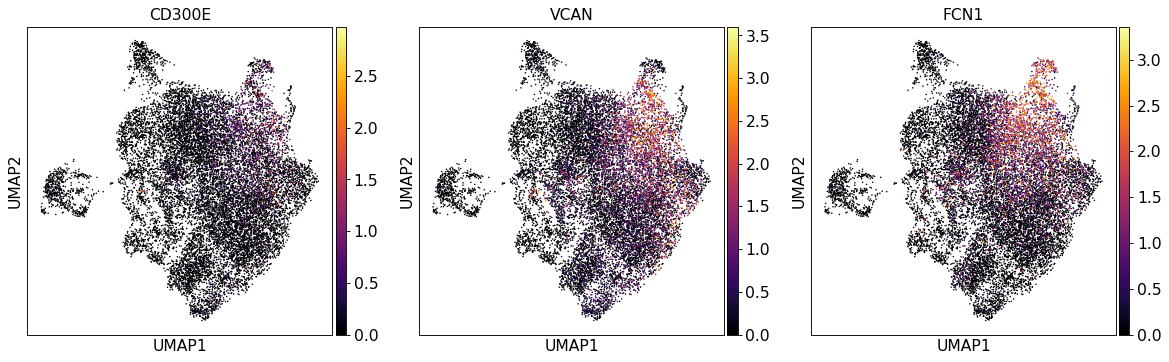

cDC1


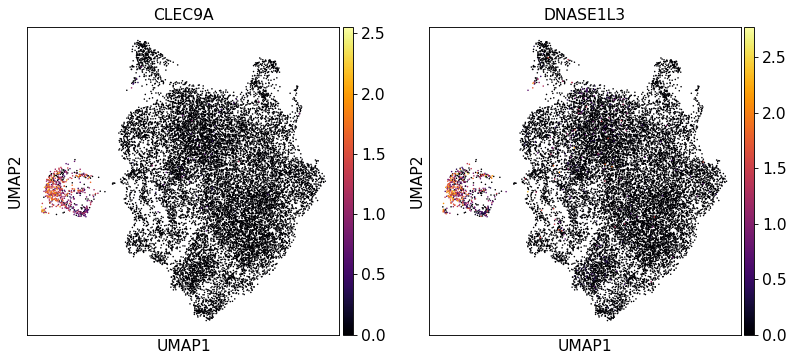

cDC2


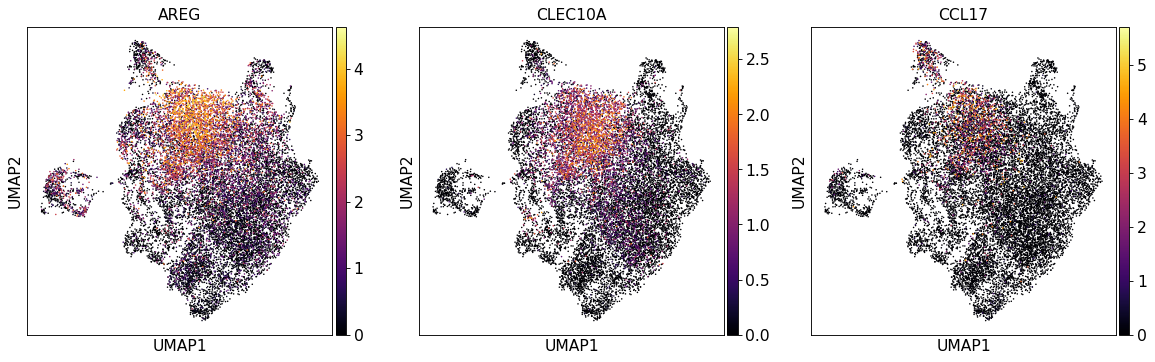

mDC_mature


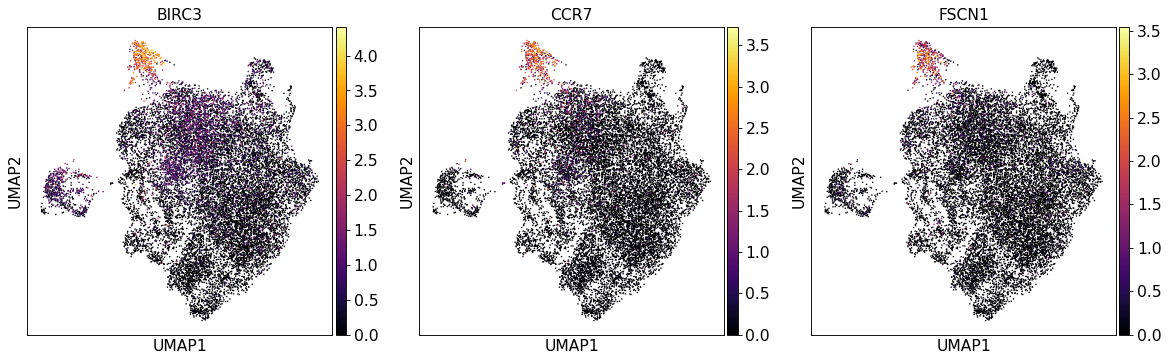

myeloid TF low


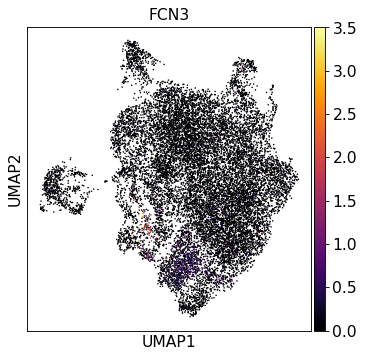

myeloid dividing


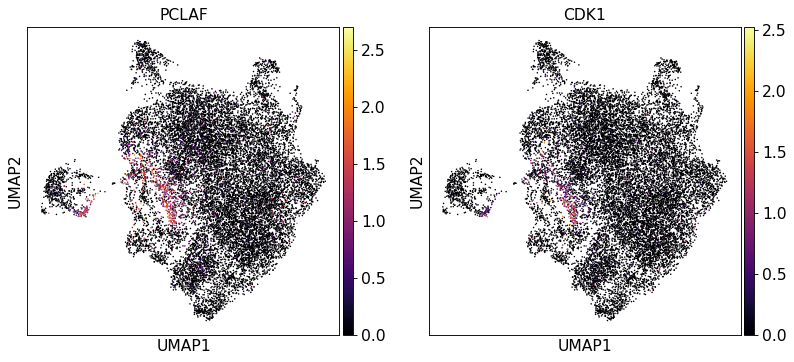

In [39]:
print("DC Lagerhans")
sc.pl.umap(adata, color=["LTB", "FCER1A"], cmap="inferno")

print("MDSC")
sc.pl.umap(adata, color=["APOBEC3A", "LILRB2"], cmap="inferno")

print("Macro M0")
sc.pl.umap(adata, color=["SLAMF9", "CCL7", "SPP1"], cmap="inferno")

print("Macro M1")
sc.pl.umap(adata, color=["SELENOP", "CCL13"], cmap="inferno")

print("Macro M2 (alevolar)")
sc.pl.umap(adata, color=["FABP4", "PCOLCE2"], cmap="inferno")

print("Mono")
sc.pl.umap(adata, color=["CD300E", "VCAN", "FCN1"], cmap="inferno")

print("cDC1")
sc.pl.umap(adata, color=["CLEC9A", "DNASE1L3"], cmap="inferno")

print("cDC2")
sc.pl.umap(adata, color=["AREG", "CLEC10A", "CCL17"], cmap="inferno")

print("mDC_mature")
sc.pl.umap(adata, color=["BIRC3", "CCR7", "FSCN1"], cmap="inferno")

print("myeloid TF low")
sc.pl.umap(adata, color=["FCN3"], cmap="inferno")

print("myeloid dividing")
sc.pl.umap(adata, color=["PCLAF", "CDK1"], cmap="inferno")

### Plot the cibersort/xCell scores by cell-type

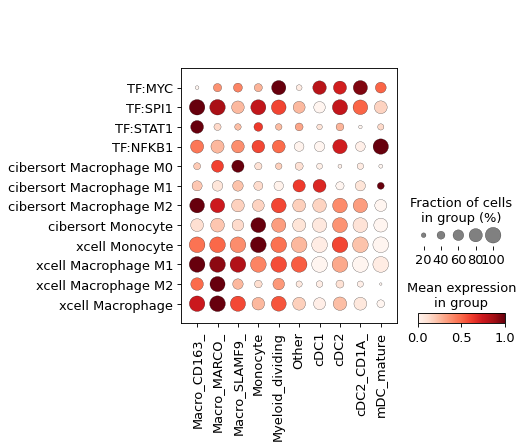

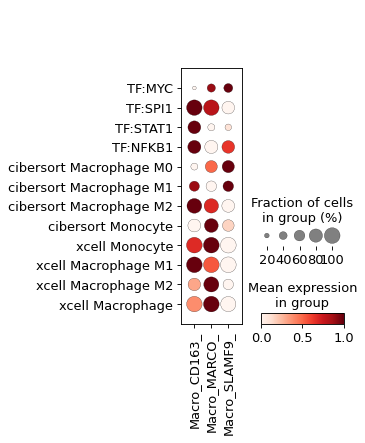

In [40]:
for tmp_adata in [
    adata,
    adata[
        adata.obs["cell_type"].str.startswith("Macro"),
    ],
]:
    sc.pl.dotplot(
        tmp_adata,
        var_names=[
            "TF:MYC",
            "TF:SPI1",
            "TF:STAT1",
            "TF:NFKB1",
            "cibersort Macrophage M0",
            "cibersort Macrophage M1",
            "cibersort Macrophage M2",
            "cibersort Monocyte",
            "xcell Monocyte",
            "xcell Macrophage M1",
            "xcell Macrophage M2",
            "xcell Macrophage",
        ],
        groupby="cell_type",
        standard_scale="var",
        swap_axes=True,
    )